# Handwritten Digit Classification



## Preparing the Data


In [7]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

We can download the data and create a PyTorch dataset using the `MNIST` class from `torchvision.datasets`.

In [8]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

image.shape: torch.Size([1, 28, 28])
Label: 5


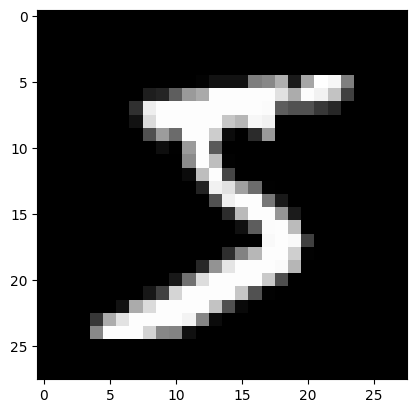

In [9]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

image.shape: torch.Size([1, 28, 28])
Label: 5


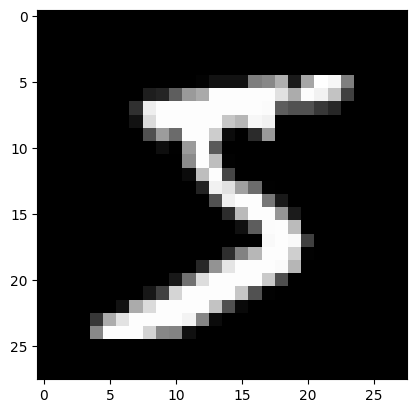

In [10]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

Next, let's use the `random_split` helper function to set aside 10000 images for our validation set.

In [11]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create PyTorch data loaders for training and validation.

In [12]:
batch_size=128

In [13]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


images.shape: torch.Size([128, 1, 28, 28])


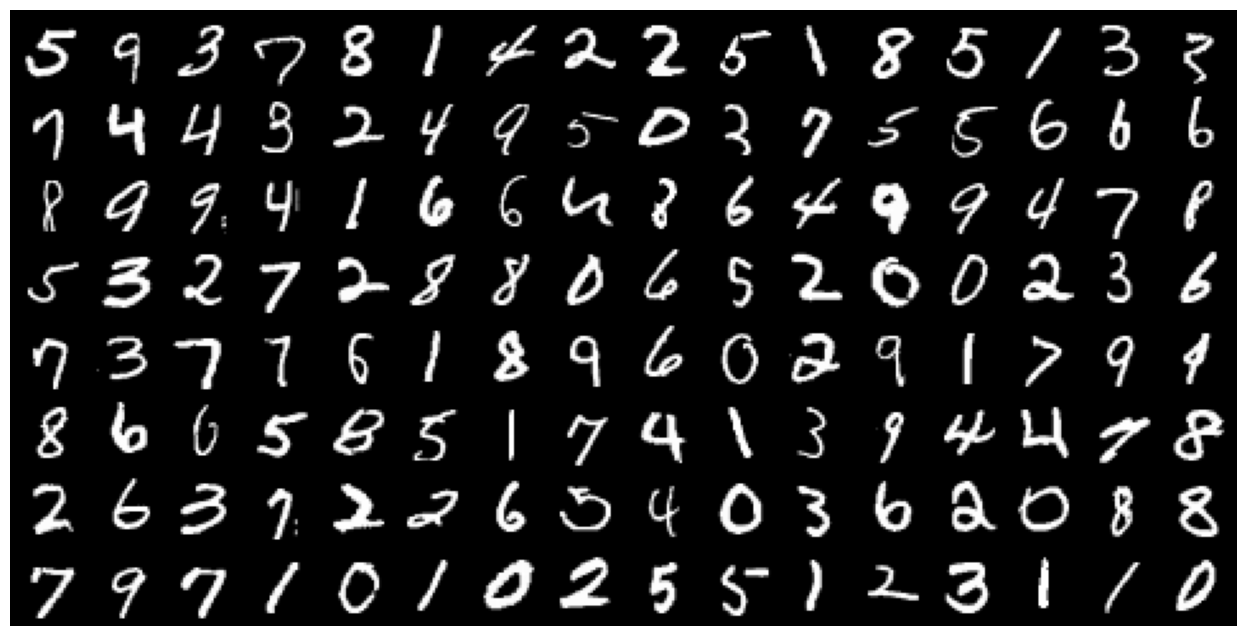

In [14]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Hidden Layers, Activation Functions and Non-Linearity



In [15]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


Next, let's create a `nn.Linear` object, which will serve as our _hidden_ layer. 

In [16]:
input_size = inputs.shape[-1]
hidden_size = 32

In [17]:
layer1 = nn.Linear(input_size, hidden_size)

We can now compute intermediate outputs for the batch of images by passing `inputs` through `layer1`.

In [18]:
inputs.shape

torch.Size([128, 784])

In [19]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


In [20]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [21]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

In [22]:
F.relu(torch.tensor([[1, -1, 0],
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

Let's apply the activation function to `layer1_outputs` and verify that negative values were replaced with 0.

In [23]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.6317180395126343
min(relu_outputs): 0.0


In [24]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [25]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [26]:
inputs.shape

torch.Size([128, 784])

In [27]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3492, grad_fn=<NllLossBackward0>)

Thus, our model transforms `inputs` into `layer2_outputs` by applying a linear transformation (using `layer1`), followed by a non-linear activation (using `F.relu`), followed by another linear transformation (using `layer2`). Let's verify this by re-computing the output using basic matrix operations.

In [28]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [29]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

In [30]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [31]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [32]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [33]:
torch.allclose(outputs2, outputs3, 1e-3)

True

## Model



In [34]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

We also need to define an `accuracy` function which calculates the accuracy of the model's prediction on an batch of inputs. It's used in `validation_step` above.

In [35]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

We'll create a model that contains a hidden layer with 32 activations.

In [36]:
input_size = 784
hidden_size = 32 
num_classes = 10

In [37]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [38]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Let's try and generate some outputs using our model. We'll take the first batch of 128 images from our dataset and pass them into our model.

In [39]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.2891528606414795
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0249, -0.0021, -0.0774,  0.1175, -0.1521,  0.0062,  0.0315, -0.0472,
          0.1039, -0.0032],
        [ 0.0672,  0.0004, -0.2871,  0.0659, -0.1357,  0.0826, -0.0499, -0.1495,
          0.0534,  0.0107]])


## Using a GPU



In [40]:
torch.cuda.is_available()

True

Let's define a helper function to ensure that our code uses the GPU if available and defaults to using the CPU if it isn't.

In [41]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [42]:
device = get_default_device()
device

device(type='cuda')

Next, let's define a function that can move data and model to a chosen device.

In [43]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [44]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move batches of data to the selected device. Interestingly, we don't need to extend an existing class to create a PyTorch datal oader. All we need is an `__iter__` method to retrieve batches of data and an `__len__` method to get the number of batches.

In [45]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

The `yield` keyword in Python is used to create a generator function that can be used within a `for` loop, as illustrated below.

In [46]:
def some_numbers():
    yield 10
    yield 20
    yield 30

for value in some_numbers():
    print(value)

10
20
30


We can now wrap our data loaders using `DeviceDataLoader`.

In [47]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Tensors moved to the GPU have a `device` property which includes that word `cuda`. Let's verify this by looking at a batch of data from `valid_dl`.

In [48]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([9, 5, 8, 1, 6, 6, 1, 9, 4, 4, 6, 4, 0, 8, 1, 0, 0, 2, 6, 2, 3, 9, 7, 2,
        5, 1, 7, 2, 0, 2, 3, 4, 9, 4, 6, 6, 0, 8, 0, 6, 3, 9, 7, 6, 3, 7, 7, 3,
        1, 1, 5, 3, 2, 2, 4, 0, 6, 7, 1, 4, 6, 3, 0, 7, 6, 4, 6, 9, 1, 3, 5, 1,
        3, 1, 0, 7, 2, 1, 9, 0, 4, 5, 7, 6, 6, 2, 8, 6, 6, 5, 1, 6, 6, 2, 9, 5,
        1, 6, 1, 6, 3, 4, 5, 0, 7, 5, 4, 3, 5, 8, 7, 4, 6, 8, 6, 2, 9, 6, 9, 9,
        8, 3, 5, 1, 0, 7, 0, 8, 5, 6, 2, 6, 3, 5, 1, 3, 5, 4, 8, 5, 0, 7, 3, 9,
        2, 6, 2, 7, 8, 8, 8, 4, 2, 0, 0, 5, 8, 4, 6, 3, 7, 9, 1, 1, 1, 6, 8, 3,
        4, 0, 0, 5, 7, 6, 8, 3, 1, 7, 1, 2, 5, 2, 9, 4, 1, 5, 8, 9, 9, 9, 3, 2,
        3, 1, 5, 2, 3, 5, 1, 4, 7, 8, 9, 2, 4, 1, 0, 7, 6, 0, 1, 7, 8, 0, 3, 2,
        4, 4, 5, 5, 1, 9, 0, 2, 3, 7, 2, 4, 8, 0, 3, 5, 0, 4, 0, 5, 8, 5, 8, 0,
        7, 0, 3, 8, 5, 5, 1, 0, 0, 6, 6, 2, 9, 3, 4, 3], device='cuda:0')


## Training the Model



In [49]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the `to_device` function to move the model's parameters to the right device.

In [50]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

Let's see how the model performs on the validation set with the initial set of weights and biases.

In [51]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.312655210494995, 'val_acc': 0.1015625}]

The initial accuracy is around 10%, as one might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

Let's train the model for five epochs and look at the results. We can use a relatively high learning rate of 0.5.

In [52]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2494, val_acc: 0.9295
Epoch [1], val_loss: 0.1702, val_acc: 0.9478
Epoch [2], val_loss: 0.1395, val_acc: 0.9598
Epoch [3], val_loss: 0.1440, val_acc: 0.9569
Epoch [4], val_loss: 0.1306, val_acc: 0.9611


96% is pretty good! Let's train the model for five more epochs at a lower learning rate of 0.1 to improve the accuracy further.

In [53]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1099, val_acc: 0.9664
Epoch [1], val_loss: 0.1109, val_acc: 0.9654
Epoch [2], val_loss: 0.1087, val_acc: 0.9671
Epoch [3], val_loss: 0.1098, val_acc: 0.9673
Epoch [4], val_loss: 0.1090, val_acc: 0.9662


We can now plot the losses & accuracies to study how the model improves over time.

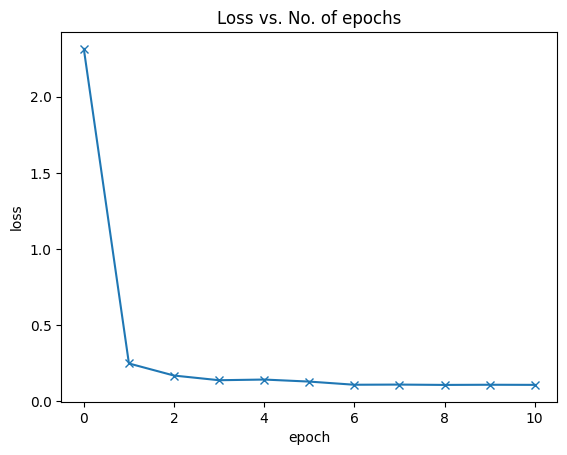

In [54]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

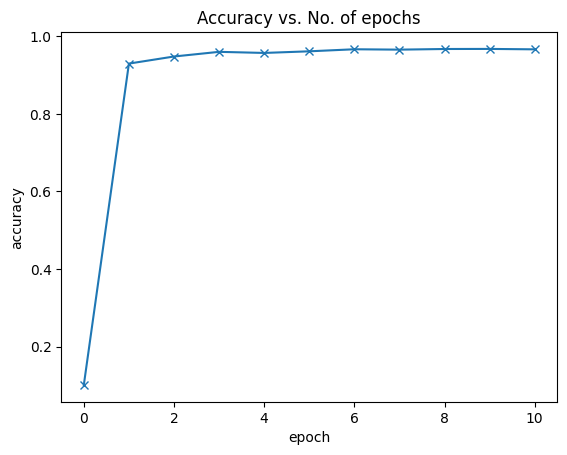

In [55]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Our current model outperforms the logistic regression model (which could only achieve around 86% accuracy) by a considerable margin! It quickly reaches an accuracy of 97% but doesn't improve much beyond this. To improve accuracy further, we need to make the model more powerful by increasing the hidden layer's size or adding more hidden layers with activations. I encourage you to try out both these approaches and see which one works better.

As a final step, we can save and commit our work using the `jovian` library.

## Testing with individual images



In [56]:
# Define test dataset
test_dataset = MNIST(root='data/',
                     train=False,
                     transform=ToTensor())

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [57]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Let's try it out with a few images.

Label: 7 , Predicted: 7


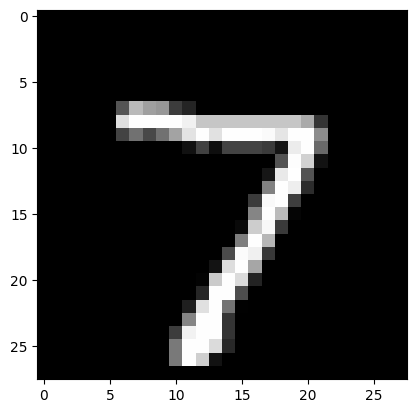

In [58]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


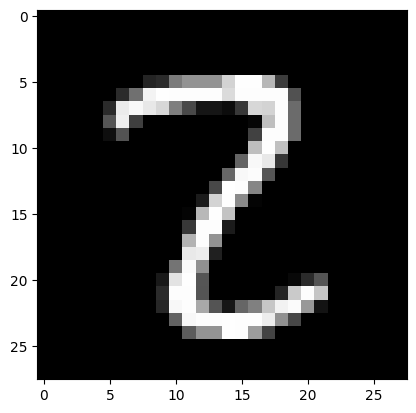

In [59]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


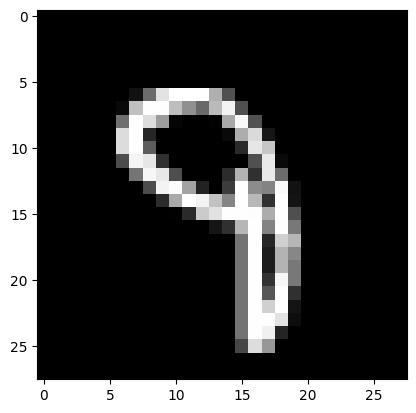

In [60]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [61]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10312367975711823, 'val_acc': 0.9677734375}